# Solved Model Training and Evaluation

This report documents a solution to ML Agents Tennis environment using A2C. The model achieved a moving average score over 100 episodes of +0.5 for the max of the agents in between 12800 and 12900 episodes.

The base code for this project comes from the cart pole implementation in Chapter 5 of [Deep Reinforcement Learning in Action](https://www.manning.com/books/deep-reinforcement-learning-in-action). The original implementation uses REINFORCE and a discrete distribution to predict which action (left or right) the cart should make to keep the pole upright.

The majority of the training code is reused from my own implementation of [Reacher in another one of my repositories](https://github.com/larryschirmer/deep_rl_continuous_control). Because of the similarity in training environment and sharing continuous control output with the same range, only minor adaptions were made.

There are some differences in the environment and training which I would like to make a note of. 

1. The Reacher environment has a fixed length episode meaning that however good or bad the agent does will make no difference as to how long each trjectory is. Tennis, however, has a variable length episode. As the agents get better and the episodes get longer, so does the amount of accumulated loss per trajectory. Environments like these have a tendency to have spikes in score followed by sudden drops. The network reached the target score before dropping in accuracy so the training passed, however had I needed to score higher I might have needed to implement PPO to keep the model parameters from changing too much between trainings.

1. The initial Reward Leadup (my lazy version of GAE, discussed below) for Reacher is low (50) and decays to 5 over the course of training. My hunch as to why Reacher responds so well to low Reward Leadup is that all of the most rewarding actions happen right next to the target location. With this same low Reward Leadup, Tennis does not reach target score. With a larger Reward Leadup, 100-25, each Tennis agent associates a larger range of previous motion to higher reward. This, I believe, reinforces the paddle motion that results in hitting the ball over the net.

1. The initial epsilon (standard deviation factor or entropy) is low for Reacher (0.3). For Tennis, though, the model has a hard time training with entropy that low. I was able to find this out by regular trial and error while adjusting the hyperparameters, but I'm not sure why this is the case.

1. The way final scores are accounted for is different for Tennis. In this environemnt the final score is the max of the two scores in each episode.

In [1]:
from unityagents import UnityEnvironment
from time import perf_counter
import pandas as pd
import copy
import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import numpy as np

from helpers import save_model, plot_losses, plot_scores

## Algorithms and Methods

The [ML Agents Tennis](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#tennis) environment outputs a state space of 8 variables and takes an action space 2 variables per agent. The environment consists of 2 agents that interact with each other by passing a ball back and forth.

It is considered passing when an moving average score over 100 episodes of +0.5 is achieved.

In [2]:
env = UnityEnvironment(file_name='Tennis.app')
# get the default brain
brain_name = env.brain_names[0]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


The model makes these predictions using a feedforward neural network with two output tails:

The first tail outputs the mean of the distribution between -1 and 1. The agent uses this output to predict where best to position the arm. The mean range is handled by the tanh activation function. The second tail outputs the predicted value of the state. The agent uses this value to predict how valuable the action is at that time step. This is useful for understanding the difference between traveling between rewards and actions that result in reward.

In [3]:
torch.manual_seed(0)


class ActorCritic(nn.Module):
    def __init__(self, params):
        super(ActorCritic, self).__init__()
        self.shared_linear0 = nn.Linear(params['input_dim'], params['shared_hidden0'])
        self.shared_linear1 = nn.Linear(params['shared_hidden0'], params['shared_hidden1'])
        self.shared_linear2 = nn.Linear(params['shared_hidden1'], params['shared_hidden2'])

        self.actor_linear0 = nn.Linear(params['shared_hidden2'], params['actor_hidden'])
        self.actor_linear1 = nn.Linear(params['actor_hidden'], params['actor_hidden'])
        self.actor_linear2 = nn.Linear(params['actor_hidden'], params['output_dim_actor'])

        self.critic_linear0 = nn.Linear(params['shared_hidden2'], params['critic_hidden'])
        self.critic_linear1 = nn.Linear(params['critic_hidden'], params['critic_hidden'])
        self.critic_linear2 = nn.Linear(params['critic_hidden'], params['output_dim_critic'])

    def forward(self, x):
        y = torch.tanh(self.shared_linear0(x))
        y = torch.tanh(self.shared_linear1(y))
        y = torch.tanh(self.shared_linear2(y))

        a = torch.tanh(self.actor_linear0(y))
        a = torch.tanh(self.actor_linear1(a))
        actor = self.actor_linear2(a)
        actor_mean = torch.tanh(actor)

        c = torch.relu(self.critic_linear0(y.detach()))
        c = torch.relu(self.critic_linear1(c))
        critic = torch.relu(self.critic_linear2(c))
        return actor_mean, critic


In [4]:
# hyperparameters
epochs = 30000
lr = 0.0001
gamma = 0.99
clc = 0.1
start_epsilon = 0.8
end_epsilon = 0.1
start_reward_leadup = 100
end_reward_leadup = 25
entropy_bonus = 0.01
batch_size = 2

input_dim = 24
shared_hidden0 = 64
shared_hidden1 = 128
shared_hidden2 = 64
actor_hidden = 32
critic_hidden = 32
output_dim_actor = 2
output_dim_critic = 1

losses = []
actor_losses = []
critic_losses = []
scores = []
ave_scores = []

params = {
    'env': env,
    'brain_name': brain_name,
    'start_epsilon': start_epsilon,
    'end_epsilon': end_epsilon,
    'epochs': epochs,
    'lr': lr,
    'gamma': gamma,
    'clc': clc,
    'start_reward_leadup': start_reward_leadup,
    'end_reward_leadup': end_reward_leadup,
    'entropy_bonus': entropy_bonus,
    'batch_size': batch_size,
    'losses': losses,
    'scores': scores,
    'ave_scores': ave_scores,
    'actor_losses': actor_losses,
    'critic_losses': critic_losses
}

model_params = {
    'input_dim': input_dim,
    'shared_hidden0': shared_hidden0,
    'shared_hidden1': shared_hidden1,
    'shared_hidden2': shared_hidden2,
    'critic_hidden': critic_hidden,
    'actor_hidden': actor_hidden,
    'output_dim_actor': output_dim_actor,
    'output_dim_critic': output_dim_critic
}

model = ActorCritic(model_params)
optimizer = torch.optim.Adam(lr=params['lr'], params=model.parameters())

The training process is managed by the `worker` function which controls when to stop training and stores the replay buffer and the highest scores. 

It also manages running each episode and training the network separately letting multiple episode trainings get batched together to smooth the loss/reward variation.

In [5]:
def worker(model, params, train=True, early_stop_threshold=5., early_stop_target=.5):

    replay = []
    optimizer = torch.optim.Adam(lr=params['lr'], params=model.parameters())
    early_stop_captures = []

    for epoch in range(params['epochs']):
        if train and len(early_stop_captures) >= early_stop_threshold:
            print("stopped early because net has reached target score")
            print(early_stop_captures)
            break

        final_score, epsilon, reward_leadup = run_episode(model, replay, params, epoch, train)
        final_score = np.max(final_score)
        params['scores'].append(final_score)
        average_score = np.mean(params['scores'][-100:])
        params['ave_scores'].append(average_score)

        if train and len(replay) >= params['batch_size']:
            loss, actor_loss, critic_loss = update_params(replay, optimizer, params)

            params['losses'].append(loss.item())
            params['actor_losses'].append(actor_loss.item())
            params['critic_losses'].append(critic_loss.item())

            if  epoch % 100 == 0:
                print("Epoch: {}, Epsilon: {:.3f}, Reward Leadup: {:.1f}, Ave Score: {:.3f}, Max: {:.4f}".format(epoch, epsilon, reward_leadup, average_score, np.amax(params['scores'])))
        
            replay = []
            if average_score > early_stop_target:
                early_stop_captures.append(average_score)

The environment is reset at the start of each episode and a new training loop begins until the environment signals that one of the agents is done.

At each training step, the agent converts the output mean from the model into a Normal Distribution with a standard distribution that is annealed over the course of training (epsilon). By annealing the value of the standard distribution, the entropy of the distribution starts off high while the accuracy of the model is low and slowly narrows the distribution as accuracy improves.

In [6]:
def run_episode(model, replay, params, epoch, train):

    env_info = params['env'].reset(train_mode=train)[params['brain_name']]
    state_ = env_info.vector_observations
    num_agents = len(env_info.agents)
    states = torch.from_numpy(state_).float()
    scores = np.zeros(num_agents)               # initialize the score

    values, logprobs, rewards, mean_entropy = [], [], [], torch.tensor(0.)
    done = False

    epsilon = np.clip((params['end_epsilon'] - params['start_epsilon']) / (params['epochs'] - 0) * epoch + params['start_epsilon'], params['end_epsilon'], params['start_epsilon'])
    step_count = 0
    while (done == False):
        step_count += 1
        actor_mean, value = model(states)
        actor_std = torch.tensor(epsilon)

        actor_mean = actor_mean.t()

        action_dist0 = torch.distributions.Normal(actor_mean[0], actor_std)
        action_dist1 = torch.distributions.Normal(actor_mean[1], actor_std)

        mean_entropy = action_dist0.entropy().mean()

        action0 = torch.clamp(action_dist0.sample(), min=-1, max=1)
        action1 = torch.clamp(action_dist1.sample(), min=-1, max=1)
        logprob0 = action_dist0.log_prob(action0)
        logprob1 = action_dist1.log_prob(action1)

        values.append(value.view(-1))
        logprobs.append([logprob0.view(-1), logprob1.view(-1)])

        action_list = [action0.detach().numpy().squeeze(), action1.detach().numpy().squeeze()]
        action_list = np.stack(action_list, axis=1)
        # send all actions to the environment
        env_info = params['env'].step(action_list)[params['brain_name']]
        # get next state (for each agent)
        state_ = env_info.vector_observations
        # get reward (for each agent)
        reward = env_info.rewards
        # see if episode finished
        done = env_info.local_done[0]

        states = torch.from_numpy(state_).float()
        rewards.append(reward)
        scores += np.array(reward)


    # Update replay buffer for each agent
    stacked_logprob0 = torch.stack([a[0] for a in logprobs], dim=1)
    stacked_logprob1 = torch.stack([a[1] for a in logprobs], dim=1)
    stacked_values = torch.stack(values, dim=1)
    stacked_rewards = np.stack(rewards, axis=1)

    for agent_index in range(len(env_info.agents)):
  
        agent_values = stacked_values[agent_index]
        agent_logprobs = [stacked_logprob0[agent_index], stacked_logprob1[agent_index]]
        agent_rewards = stacked_rewards[agent_index]

        actor_losses, critic_losses, losses, reward_leadup = get_trjectory_loss(agent_values, agent_logprobs, agent_rewards, mean_entropy, epoch, params)
        replay.append((scores[agent_index], actor_losses, critic_losses, losses))

    return scores, epsilon, reward_leadup

Information is collected at each trajectory and used to calculate the loss from that episode.

In [7]:
def get_trjectory_loss(values, logprobs, rewards, mean_entropy, epoch, params):
    reward_leadup = np.clip((params['end_reward_leadup'] - params['start_reward_leadup']) / (params['epochs'] - 0) * epoch + params['start_reward_leadup'], params['end_reward_leadup'], params['start_reward_leadup'])
    [logprob0, logprob1] = logprobs

    values = values.flip(dims=(0,))
    rewards = torch.Tensor(rewards).flip(dims=(0,))
    logprob0 = logprob0.flip(dims=(0,))
    logprob1 = logprob1.flip(dims=(0,))

    Returns = []
    total_return = torch.Tensor([0])
    leadup = 0

    for reward_index in range(len(rewards)):
        if rewards[reward_index].item() > 0:
            leadup = reward_leadup
        if leadup == 0:
            total_return = torch.Tensor([0])
        
        total_return = rewards[reward_index] + total_return * params['gamma']
        Returns.append(total_return)
        leadup = leadup - 1 if leadup > 0 else 0

    Returns = torch.stack(Returns).view(-1)
    Returns = F.normalize(Returns, dim=0)

    actor_loss0 = -logprob0 * (Returns - values.detach())
    actor_loss1 = -logprob1 * (Returns - values.detach())
    critic_loss = torch.pow(values - Returns, 2)

    actor_loss0 = actor_loss0.sum()
    actor_loss1 = actor_loss1.sum()
    critic_loss = critic_loss.sum()

    loss0 = actor_loss0 + params['clc']*critic_loss + params['entropy_bonus'] * mean_entropy
    loss1 = actor_loss1 + params['clc']*critic_loss + params['entropy_bonus'] * mean_entropy

    actor_losses = (actor_loss0, actor_loss1)
    losses = (loss0, loss1)

    return actor_losses, critic_loss, losses, reward_leadup

The loss of each trajectory is calculated using the general [REINFORCE formula](https://pytorch.org/docs/stable/distributions.html#score-function). The most notable change to this implementation though is how rewards are discounted.

```python
Returns = []
total_return = torch.Tensor([0])
leadup = 0

for reward_index in range(len(rewards)):
    if rewards[reward_index].item() > 0:
        leadup = reward_leadup
    if leadup == 0:
        total_return = torch.Tensor([0])
    
    total_return = rewards[reward_index] + total_return * params['gamma']
    Returns.append(total_return)
    leadup = leadup - 1 if leadup > 0 else 0
```

I understand the concept of GAE (Generalized Advantage Estimation). This technique changes how far ahead the agent can look in terms of future reward. I, however, had issues implementing the technique so I ended up adding a simpler variation of the technique I called Reward Leadup. What Reward Leadup does is only reward actions closer to where they happen. This solves the issue where random motion hundreds of timesteps away from when a reward occurs confuses the model into thinking that random useless motion somehow contributed to that reward occurring.

The trick is that after the rewards are reversed, if there is not a reward during the leadup window then the reward is not cumulative. The result of this change makes future reward (from the perspective of the agent) much higher right when rewards occurs, then reinforcing the actions that lead to the reward.

In [8]:
def update_params(replay, optimizer, params):
    loss0 = torch.tensor(0.)
    loss1 = torch.tensor(0.)
    actor_loss0 = torch.tensor(0.)
    actor_loss1 = torch.tensor(0.)
    critic_loss = torch.tensor(0.)

    for trajectory in replay:
        rewards_sum, actor_losses, critic_loss, losses = trajectory
        loss0 += losses[0]
        loss1 += losses[1]
        actor_loss0 += actor_losses[0]
        actor_loss1 += actor_losses[1]
        critic_loss += critic_loss
    

    loss0 = loss0 / len(replay)
    loss1 = loss1 / len(replay)
    actor_loss0 = actor_loss0 / len(replay)
    actor_loss1 = actor_loss1 / len(replay)
    critic_loss = critic_loss / len(replay)

    loss_mean = (loss0 + loss1) / 2

    optimizer.zero_grad()
    loss_mean.backward()
    optimizer.step()

    actor_loss_sum = actor_loss0 + actor_loss1

    return loss_mean, actor_loss_sum, critic_loss

Losses from each trajectory are batched together and the model is updated using the average of the loss across the batch. This is done to reduce to the variability in training data and smooth loss.

## Training Evaluation

Model training stopped early at between 12800 and 12900 reaching a target moving average score of 0.5 for the max of both agents.

In [9]:
start = perf_counter()
worker(model, params)
save_model(model, 'actor_critic.pt')
end = perf_counter()
print((end - start))

Epoch: 0, Epsilon: 0.800, Reward Leadup: 100.0, Ave Score: 0.000, Max: 0.0000
Epoch: 100, Epsilon: 0.798, Reward Leadup: 99.8, Ave Score: 0.007, Max: 0.1000
Epoch: 200, Epsilon: 0.795, Reward Leadup: 99.5, Ave Score: 0.012, Max: 0.1000
Epoch: 300, Epsilon: 0.793, Reward Leadup: 99.2, Ave Score: 0.011, Max: 0.1000
Epoch: 400, Epsilon: 0.791, Reward Leadup: 99.0, Ave Score: 0.003, Max: 0.1000
Epoch: 500, Epsilon: 0.788, Reward Leadup: 98.8, Ave Score: 0.007, Max: 0.1000
Epoch: 600, Epsilon: 0.786, Reward Leadup: 98.5, Ave Score: 0.009, Max: 0.1000
Epoch: 700, Epsilon: 0.784, Reward Leadup: 98.2, Ave Score: 0.011, Max: 0.1000
Epoch: 800, Epsilon: 0.781, Reward Leadup: 98.0, Ave Score: 0.012, Max: 0.1000
Epoch: 900, Epsilon: 0.779, Reward Leadup: 97.8, Ave Score: 0.010, Max: 0.1000
Epoch: 1000, Epsilon: 0.777, Reward Leadup: 97.5, Ave Score: 0.019, Max: 0.1000
Epoch: 1100, Epsilon: 0.774, Reward Leadup: 97.2, Ave Score: 0.016, Max: 0.1000
Epoch: 1200, Epsilon: 0.772, Reward Leadup: 97.0, A

Epoch: 10300, Epsilon: 0.560, Reward Leadup: 74.2, Ave Score: 0.132, Max: 1.6000
Epoch: 10400, Epsilon: 0.557, Reward Leadup: 74.0, Ave Score: 0.190, Max: 1.6000
Epoch: 10500, Epsilon: 0.555, Reward Leadup: 73.8, Ave Score: 0.215, Max: 1.6000
Epoch: 10600, Epsilon: 0.553, Reward Leadup: 73.5, Ave Score: 0.179, Max: 1.6000
Epoch: 10700, Epsilon: 0.550, Reward Leadup: 73.2, Ave Score: 0.214, Max: 1.6000
Epoch: 10800, Epsilon: 0.548, Reward Leadup: 73.0, Ave Score: 0.276, Max: 1.7000
Epoch: 10900, Epsilon: 0.546, Reward Leadup: 72.8, Ave Score: 0.201, Max: 1.7000
Epoch: 11000, Epsilon: 0.543, Reward Leadup: 72.5, Ave Score: 0.236, Max: 1.7000
Epoch: 11100, Epsilon: 0.541, Reward Leadup: 72.2, Ave Score: 0.235, Max: 1.7000
Epoch: 11200, Epsilon: 0.539, Reward Leadup: 72.0, Ave Score: 0.217, Max: 1.7000
Epoch: 11300, Epsilon: 0.536, Reward Leadup: 71.8, Ave Score: 0.282, Max: 1.9000
Epoch: 11400, Epsilon: 0.534, Reward Leadup: 71.5, Ave Score: 0.224, Max: 1.9000
Epoch: 11500, Epsilon: 0.532

**Average Score and Scores each Episode**

- Black: Moving Average score of the max of each agent at each episode. 
- Gray: Average score of the max of each agent at each episode

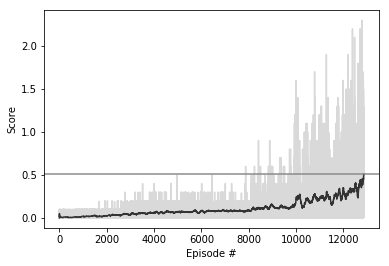

<Figure size 432x288 with 0 Axes>

In [10]:
plot_scores(params['scores'], params['ave_scores'], filename='scores.png', show=True)

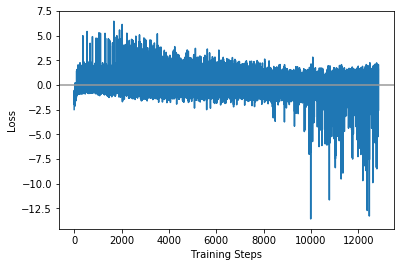

<Figure size 432x288 with 0 Axes>

In [11]:
plot_losses(params['losses'], 'loss.png', show=True)

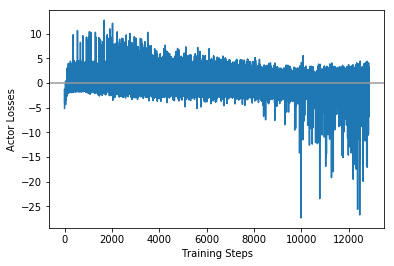

<Figure size 432x288 with 0 Axes>

In [12]:
plot_losses(params['actor_losses'], filename='actor_loss.png', plotName="Actor Losses", show=True)

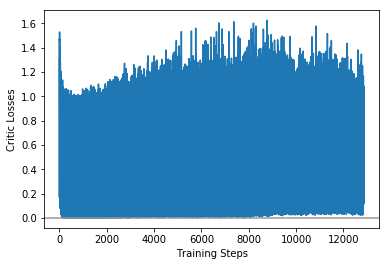

<Figure size 432x288 with 0 Axes>

In [13]:
plot_losses(params['critic_losses'], filename='critic_loss.png', plotName="Critic Losses", show=True)

In [14]:
env.close()

## Future Work
In the future I could improve this project by

### Implementing GAE and PPO
In this project, I implemented my own variation of gae that had a fixed reward look ahead window. GAE would improve on my variation by fading the rewards with a discounting factor. PPO would smooth the training process by stopping the networking parameters from changing a lot during back propagation. This is an issue with reinforcement learning because the training data is generated each episode and has high variability. Giving the network more tools while training variable length trajectories helps smooth the training process and produce higher rewards.